# HW3: Dueling Double DQN

This homework demands you to implement a DQN with some advanced tricks from RAINBOW:
* N-step target without off-policy correction
* Dueling Networks

Papers:
* DQN: https://arxiv.org/abs/1312.5602

* RAINBOW: https://arxiv.org/abs/1710.02298

* APE-X paper: https://arxiv.org/abs/1803.00933



You will run your agent on Atari Breakout environment: https://ale.farama.org/environments/breakout/

Atari docs: https://ale.farama.org/environments/

A paper about Atari benchmark in general: https://arxiv.org/abs/1709.06009

In [ ]:
!wget -q https://raw.githubusercontent.com/laktionov/RL-course/2025/hw3/atari_wrappers.py
!wget -q https://raw.githubusercontent.com/laktionov/RL-course/2025/hw3/utils.py
!wget -q https://raw.githubusercontent.com/laktionov/RL-course/2025/hw3/framebuffer.py

In [1]:
%load_ext autoreload
%autoreload 2

We are using the latest version of Gymnasium

In [2]:
import gymnasium as gym
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
import ale_py

gym.register_envs(ale_py)
%matplotlib inline

Let's play some old videogames. This time we're gonna apply approximate q-learning to an atari game called Breakout. It's not the hardest thing out there, but it's definitely way more complex than anything we tried before.

In [3]:
ENV_NAME = "ALE/Breakout-v5"

# Preprocessing

Let's see what observations look like.

A.L.E: Arcade Learning Environment (version 0.11.0+dfae0bd)
[Powered by Stella]


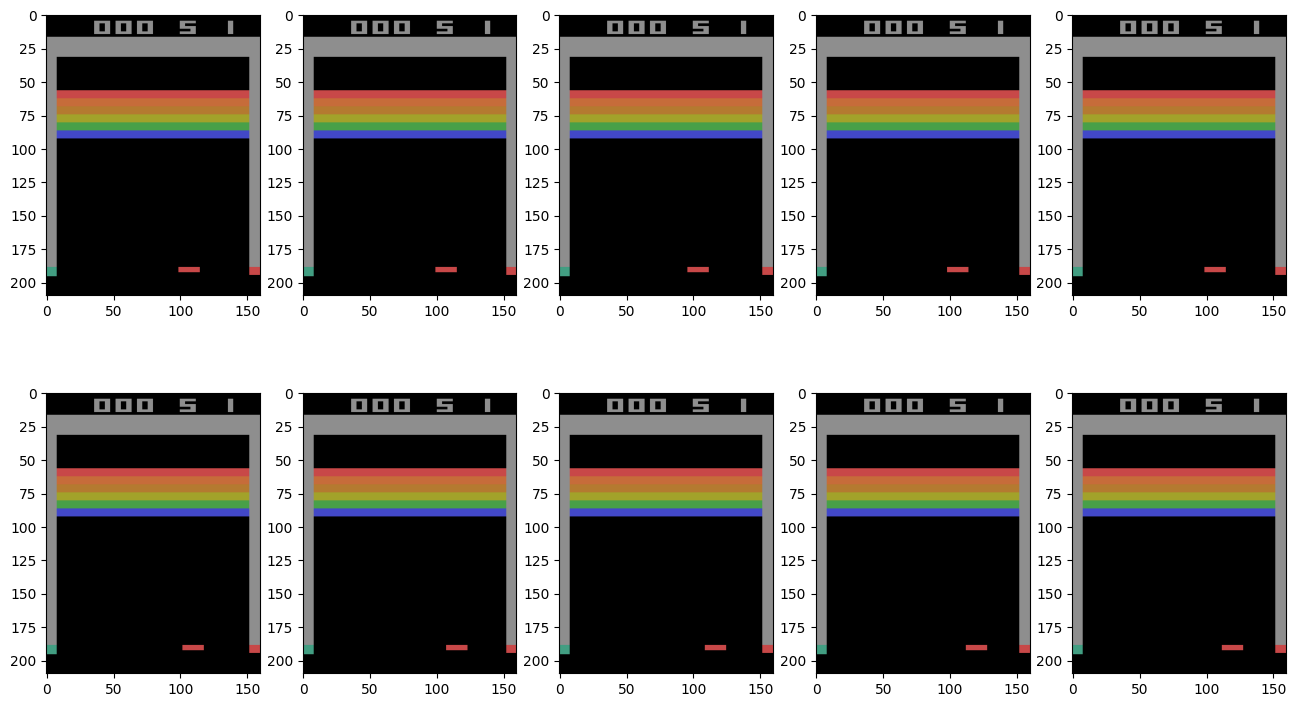

In [4]:
env = gym.make(ENV_NAME, render_mode="rgb_array",
               frameskip=1, repeat_action_probability=0.0)
env.reset()

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))

for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(env.render())
        env.step(env.action_space.sample())
plt.show()

### Processing game image

Raw atari images are large, 210x160x3 by default. However, we don't need that level of detail in order to learn them.

We can thus save a lot of time by preprocessing game image, including
* Resizing to a smaller shape, 64 x 64
* Converting to grayscale
* Cropping irrelevant image parts (top, bottom and edges)

Also please keep one dimension for channel so that final shape would be 1 x 64 x 64.

Tip: You can implement your own grayscale converter and assign a huge weight to the red channel. This trick is not necessary but it will speed up learning.

In [5]:
from gymnasium import ObservationWrapper
from gymnasium.spaces import Box
import cv2


class PreprocessAtariObs(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and grayscales it."""
        super().__init__(env)

        self.img_size = (1, 64, 64)
        self.observation_space = Box(0.0, 1.0, self.img_size)


    def _to_gray_scale(self, rgb, channel_weights=[0.8, 0.1, 0.1]):
        return np.dot(rgb[...,:3], channel_weights)[None, :, :]

    def observation(self, img):
        """what happens to each observation"""

        # Here's what you need to do:
        #  * crop image, remove irrelevant parts
        #  * resize image to self.img_size
        #     (use imresize from any library you want,
        #      e.g. opencv, skimage, PIL, keras)
        #  * cast image to grayscale
        #  * convert image pixels to (0,1) range, float32 type
        img = img[31:-17, 7:-8] # crop
        img = cv2.resize(img, (64, 64)) # resize
        img = self._to_gray_scale(img) # grayscale
        img = img.astype(np.float32) / 256 # float
        return img

Formal tests seem fine. Here's an example of what you'll get.


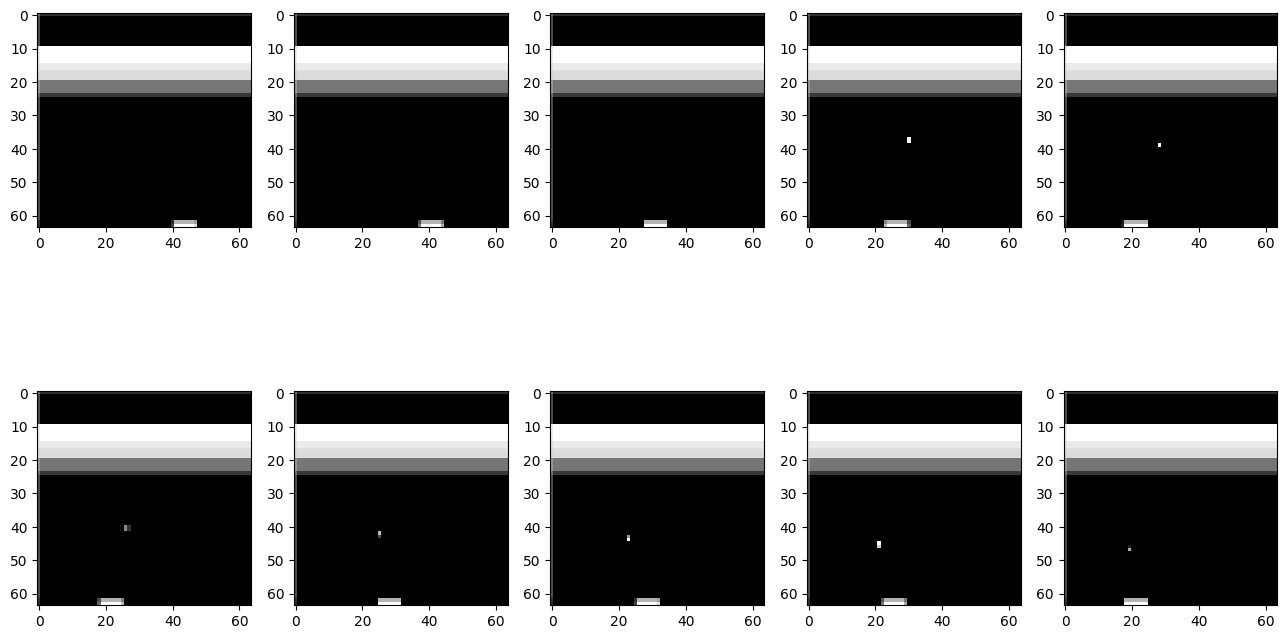

In [6]:
# spawn game instance for tests
env = gym.make(ENV_NAME, render_mode="rgb_array")  # create raw env
env = PreprocessAtariObs(env)
observation_shape = env.observation_space.shape
n_actions = env.action_space.n
env.reset()
obs, _, _, _, _ = env.step(env.action_space.sample())

# test observation
assert obs.ndim == 3, "observation must be [channel, h, w] even if there's just one channel"
assert obs.shape == observation_shape
assert obs.dtype == 'float32'
assert len(np.unique(obs)) > 2, "your image must not be binary"
assert 0 <= np.min(obs) and np.max(
    obs) <= 1, "convert image pixels to [0,1] range"
assert np.max(obs) > 1. / 256, "you probably divided on 256 twice"

print("Formal tests seem fine. Here's an example of what you'll get.")

n_cols = 5
n_rows = 2
fig = plt.figure(figsize=(16, 9))
obs, _ = env.reset()
for row in range(n_rows):
    for col in range(n_cols):
        ax = fig.add_subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(obs[0, :, :], interpolation='none', cmap='gray')
        obs, _, _, _, _ = env.step(env.action_space.sample())
plt.show()

# Wrapping

**About the game:** You have 5 lives and get points for breaking the wall. Higher bricks cost more than the lower ones. There are 4 actions: start game (should be called at the beginning and after each life is lost), move left, move right and do nothing. There are some common wrappers used for Atari environments.

In [7]:
import atari_wrappers

def PrimaryAtariWrap(env, clip_rewards=True):
    # This wrapper holds the same action for <skip> frames and outputs
    # the maximal pixel value of 2 last frames (to handle blinking
    # in some envs)
    env = atari_wrappers.MaxAndSkipEnv(env, skip=4)

    # This wrapper sends done=True when each life is lost
    # (not all the 5 lives that are givern by the game rules).
    # It should make easier for the agent to understand that losing is bad.
    env = atari_wrappers.EpisodicLifeEnv(env)

    # This wrapper laucnhes the ball when an episode starts.
    # Without it the agent has to learn this action, too.
    # Actually it can but learning would take longer.
    env = atari_wrappers.FireResetEnv(env)

    # This wrapper transforms rewards to {-1, 0, 1} according to their sign
    if clip_rewards:
        env = atari_wrappers.ClipRewardEnv(env)

    # This wrapper is yours :)
    env = PreprocessAtariObs(env)
    return env

# Frame Buffer

Our agent can only process one observation at a time, so we gotta make sure it contains enough information to find optimal actions. For instance, agent has to react to moving objects so he must be able to measure object's velocity. To do so, we introduce a buffer that stores 4 last images. This time everything is pre-implemented for you.

In [8]:
from framebuffer import FrameBuffer
import utils

def make_env(clip_rewards=True, seed=None):
    env = gym.make(ENV_NAME, render_mode="rgb_array")  # create raw env
    env = PrimaryAtariWrap(env, clip_rewards)
    env = FrameBuffer(env, n_frames=4, dim_order='pytorch')
    return env

env = make_env()
env.reset()
n_actions = env.action_space.n
state_shape = env.observation_space.shape
n_actions, state_shape

(np.int64(4), (4, 64, 64))

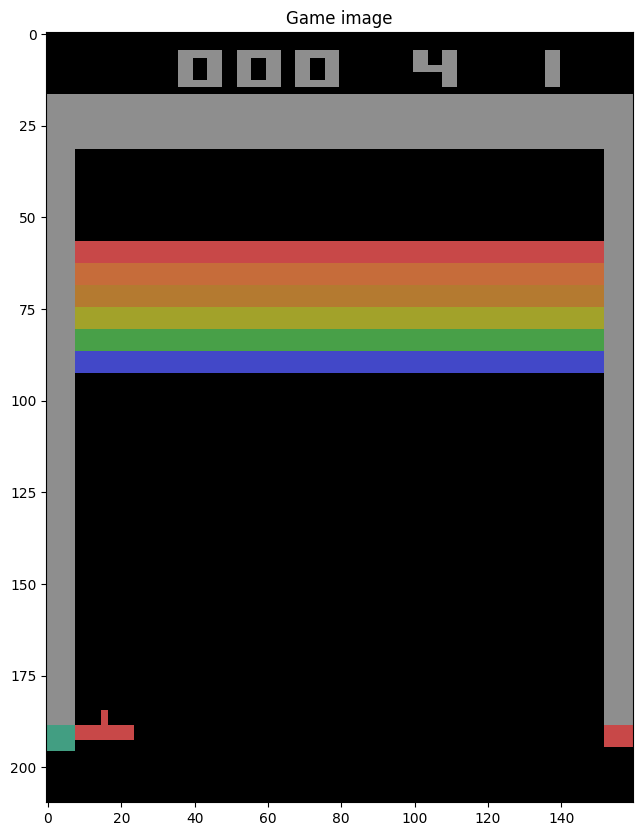

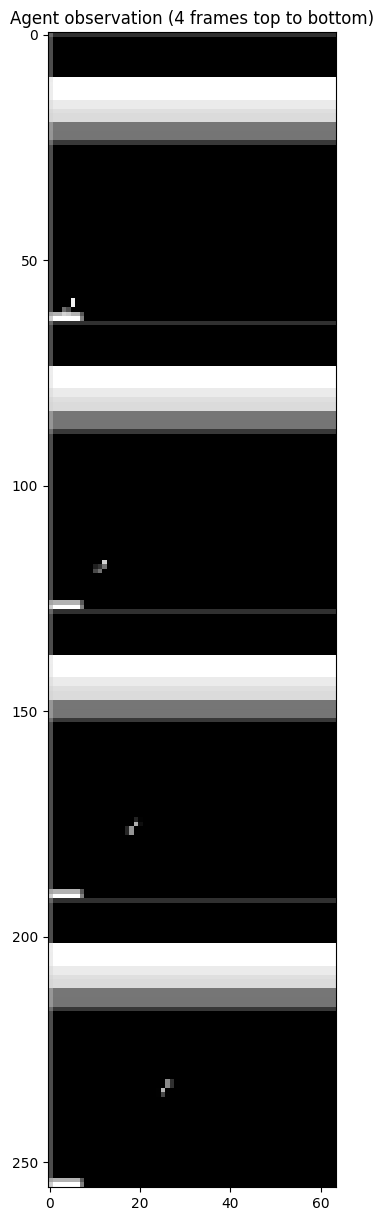

In [9]:
for _ in range(12):
    obs, _, _, _, _ = env.step(env.action_space.sample())

plt.figure(figsize=[12,10])
plt.title("Game image")
plt.imshow(env.render())
plt.show()

plt.figure(figsize=[15, 15])
plt.title("Agent observation (4 frames top to bottom)")
plt.imshow(utils.img_by_obs(obs, state_shape), cmap='gray')
plt.show()

# Dueling DDQN as it is


* Dueling network
* Replay buffer
* Double DQN with target network

### Dueling network (1 point)
Paper: https://arxiv.org/pdf/1511.06581.pdf
$$Q_{\theta}(s, a) = V_{\xi}(s) + A_{\psi}(s, a) - \frac{\sum_{a'}A_{\psi}(s, a')}{N_{actions}},$$

This is what it looks like:

Expects height=width=64

<!-- <img src="img/dueling_basic.png" alt="dueling_basic" width="500"/> -->
![img](https://github.com/yandexdataschool/Practical_RL/raw/master/week04_approx_rl/img/dueling_basic.png)

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device('cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
def conv2d_size_out(size, kernel_size, stride):
    """
    common use case:
    cur_layer_img_w = conv2d_size_out(cur_layer_img_w, kernel_size, stride)
    cur_layer_img_h = conv2d_size_out(cur_layer_img_h, kernel_size, stride)
    to understand the shape for dense layer's input
    """
    return (size - (kernel_size - 1) - 1) // stride  + 1

In [12]:
class DuelingNetwork(nn.Module):
    """
    Implement the Dueling DQN logic.
    """
    def __init__(self, n_actions, inp_size, hidden_size) -> None:
        super().__init__()
        self.n_actions = n_actions
        self.inp_size = inp_size
        self.hidden_size = hidden_size
        self.advantage_head = nn.Sequential(
            #(7x7x64)
            nn.Dropout(p=0.2),
            nn.Linear(inp_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_size, n_actions)
        )
        self.value_head = nn.Sequential(
            #(7x7x64)
            nn.Dropout(p=0.2),
            nn.Linear(inp_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        assert x.ndim == 2, x.shape  # (batch_size, n_features)
        # When calculating the mean advantage, please, remember, x is a batched input!
        state_value = self.value_head(x)
        advantage_value = self.advantage_head(x)
        state_action_value = state_value + advantage_value - torch.mean(advantage_value, dim=-1, keepdim=True)
        return state_action_value, state_value, advantage_value


Since both the advantage and the value stream propagate gradients to the last convolutional layer in the backward pass, we rescale the combined gradient entering the last convolutional layer by $\frac{1}{\sqrt{2}}$. This simple heuristic mildly increases stability.

In [13]:
class GradScalerFunctional(torch.autograd.Function):
    """
    A torch.autograd.Function works as Identity on forward pass
    and scales the gradient by scale_factor on backward pass.
    """
    @staticmethod
    def forward(ctx, input, scale_factor):
        ctx.scale_factor = scale_factor
        return input

    @staticmethod
    def backward(ctx, grad_output):
        scale_factor = ctx.scale_factor
        grad_input = grad_output * scale_factor
        return grad_input, None


class GradScaler(nn.Module):
    """
    An nn.Module incapsulating GradScalerFunctional
    """
    def __init__(self, scale_factor: float):
        super().__init__()
        self.scale_factor = scale_factor

    def forward(self, x):
        return GradScalerFunctional.apply(x, self.scale_factor)

In [14]:
class DQNAgent(nn.Module):
    def __init__(self, state_shape, n_actions, epsilon=0):

        super().__init__()
        self.epsilon = epsilon
        self.n_actions = n_actions
        self.state_shape = state_shape

        # Define your network body here. Please make sure agent is fully contained here
        channels_conf = [4, 16, 32, 64]
        self.conv_block = nn.Sequential(
            *[
                nn.Sequential(
                    nn.Conv2d(channels_conf[i], channels_conf[i + 1], 3, 2),
                    nn.ReLU()
                    )
                for i in range(len(channels_conf) - 1)
            ]
        )
        self.conv_block += nn.Sequential(
            GradScaler(2 ** (-0.5)),
            nn.Flatten()
            )
        inp_widths = [state_shape[2]]
        inp_highs = [state_shape[1]]
        for i in range(len(channels_conf) - 1):
            inp_widths.append(conv2d_size_out(inp_widths[-1], 3, 2))
            inp_highs.append(conv2d_size_out(inp_highs[-1], 3, 2))
        inp_size = inp_widths[-1] * inp_highs[-1] * channels_conf[-1]
        self.dueling_backbone = DuelingNetwork(n_actions, inp_size, 256)

    def forward(self, state_t):
        """
        takes agent's observation (tensor), returns qvalues (tensor)
        :param state_t: a batch of 4-frame buffers, shape = [batch_size, 4, h, w]
        """
        # Use your network to compute qvalues for given state
        out = self.conv_block(state_t)
        q_values, _, _ = self.dueling_backbone(out)
        return q_values

    @torch.inference_mode()
    def get_qvalues(self, states: np.ndarray) -> np.ndarray:
        """
        like forward, but works on numpy arrays, not tensors
        """
        state_t = torch.tensor(states, dtype=torch.float32).to(device)
        q_values = self.forward(state_t)
        return q_values.cpu().numpy()

    def sample_actions_by_qvalues(self, qvalues: np.ndarray, greedy: bool = False) -> np.ndarray:
        """pick actions given qvalues based on epsilon-greedy exploration strategy."""
        batch_size, n_actions = qvalues.shape
        eps = self.epsilon
        exploration_mask = np.random.rand(batch_size) < eps
        best_actions = np.argmax(qvalues, axis=1)
        if greedy:
            return best_actions
        sampled_actions = np.random.randint(0, self.n_actions, batch_size)
        best_actions[exploration_mask] = sampled_actions[exploration_mask]
        return best_actions

    def sample_actions(self, states: np.ndarray, greedy: bool = False) -> np.ndarray:
        q_values = self.get_qvalues(states)
        actions = self.sample_actions_by_qvalues(q_values, greedy)
        return actions

In [15]:
agent = DQNAgent(state_shape, n_actions, epsilon=0.5).to(device)

In [16]:
agent

DQNAgent(
  (conv_block): Sequential(
    (0): Sequential(
      (0): Conv2d(4, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
    )
    (3): GradScaler()
    (4): Flatten(start_dim=1, end_dim=-1)
  )
  (dueling_backbone): DuelingNetwork(
    (advantage_head): Sequential(
      (0): Dropout(p=0.2, inplace=False)
      (1): Linear(in_features=3136, out_features=256, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=256, out_features=4, bias=True)
    )
    (value_head): Sequential(
      (0): Dropout(p=0.2, inplace=False)
      (1): Linear(in_features=3136, out_features=256, bias=True)
      (2): ReLU()
      (3): Dropout(p=0.2, inplace=False)
      (4): Linear(in_features=256, out_features=1, bias=True)
    )
  )
)

Now let's try out our agent to see if it raises any errors.

In [17]:
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    for _ in range(n_games):
        s, _ = env.reset()
        reward = 0
        for _ in range(t_max):
            action = agent.sample_actions([s], greedy=greedy)[0]
            s, r, terminated, truncated, _ = env.step(action)
            reward += r
            if terminated or truncated:
                break
        rewards.append(reward)
    return np.mean(rewards)

In [18]:
evaluate(env, agent, n_games=1)

/tmp/ipykernel_3051474/3435822049.py:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  state_t = torch.tensor(states, dtype=torch.float32).to(device)


np.float64(1.0)

# Experience Replay
There's a powerful technique that you can use to improve sample efficiency for off-policy algorithms: Experience Replay. The catch is that you can train Q-learning and EV-SARSA on `<s,a,r,s'>` tuples even if they aren't sampled under current agent's policy. So here's what we're gonna do:

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/exp_replay.png width=640>

#### Training with experience replay
1. Play game, sample `<s,a,r,s'>`.
2. Update q-values based on `<s,a,r,s'>`.
3. Store `<s,a,r,s'>` transition in a buffer.
 3. If buffer is full, delete earliest data.
4. Sample K such transitions from that buffer and update q-values based on them.

#### The interface is fairly simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - saves (s,a,r,s',done) tuple into the buffer
* `exp_replay.sample(batch_size)` - returns observations, actions, rewards, next_observations and is_done for `batch_size` random samples.
* `len(exp_replay)` - returns number of elements stored in replay buffer.


To enable such training, first we must implement a memory structure that would act like such a buffer.

In [19]:
class ReplayBuffer:
    def __init__(self, size):
        """
        Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.

        Note: for this assignment you can pick any data structure you want.
              If you want to keep it simple, you can store a list of tuples of (s, a, r, s') in self._storage
              However you may find out there are faster and/or more memory-efficient ways to do so.
        """
        self.size = size
        self._storage = []

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        '''
        Make sure, _storage will not exceed _maxsize.
        Make sure, FIFO rule is being followed: the oldest examples has to be removed earlier
        '''
        data = (obs_t, action, reward, obs_tp1, done)
        self._storage.append(data)
        self._storage = self._storage[-self.size:]


    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        # randomly generate batch_size integers
        # to be used as indexes of samples
        indices = np.random.randint(0, len(self), batch_size)

        # collect <s,a,r,s',done> for each index
        states, actions, rewards, next_states, is_done = [], [], [], [], []
        for idx in indices:
            states.append(self._storage[idx][0])
            actions.append(self._storage[idx][1])
            rewards.append(self._storage[idx][2])
            next_states.append(self._storage[idx][3])
            is_done.append(self._storage[idx][4])
        states = np.array(states)
        actions = np.array(actions)
        rewards = np.array(rewards)
        next_states = np.array(next_states)
        is_done = np.array(is_done)

        # <states>, <actions>, <rewards>, <next_states>, <is_done>
        return states, actions, rewards, next_states, is_done

In [20]:
#from replay_buffer import ReplayBuffer

exp_replay = ReplayBuffer(10)

for _ in range(30):
    exp_replay.add(env.reset()[0], env.action_space.sample(),
                   1.0, env.reset()[0], done=False)

obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    5)

assert len(exp_replay) == 10, "experience replay size should be 10 because that's what maximum capacity is"

In [21]:
def play_and_record(initial_state, agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n_steps, record every (s,a,r,s', done) to replay buffer.
    Whenever game ends, add record with done=True and reset the game.
    It is guaranteed that env has terminated=False when passed to this function.

    PLEASE DO NOT RESET ENV UNLESS IT IS "DONE"

    :returns: return sum of rewards over time and the state in which the env stays
    """
    s = initial_state
    sum_rewards = 0

    # Play the game for n_steps as per instructions above
    for _ in range(n_steps):
        action = agent.sample_actions([s])[0]
        next_s, r, terminated, truncated, _ = env.step(action)
        exp_replay.add(s, action, r, next_s, terminated)
        sum_rewards += r
        s = next_s
        if terminated or truncated:
            s, _ = env.reset()

    return sum_rewards, s

In [22]:
# testing your code.
exp_replay = ReplayBuffer(2000)

state, _ = env.reset()
play_and_record(state, agent, env, exp_replay, n_steps=1000)

# if you're using your own experience replay buffer, some of those tests may need correction.
# just make sure you know what your code does
assert len(exp_replay) == 1000, "play_and_record should have added exactly 1000 steps, "\
                                 "but instead added %i" % len(exp_replay)
is_dones = list(zip(*exp_replay._storage))[-1]

# assert 0 < np.mean(is_dones) < 0.1, "Please make sure you restart the game whenever it is 'done' and record the is_done correctly into the buffer."\
#                                     "Got %f is_done rate over %i steps. [If you think it's your tough luck, just re-run the test]" % (
#                                         np.mean(is_dones), len(exp_replay))

for _ in range(100):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)
    assert obs_batch.shape == next_obs_batch.shape == (10,) + state_shape
    assert act_batch.shape == (10,), "actions batch should have shape (10,) but is instead %s" % str(act_batch.shape)
    assert reward_batch.shape == (10,), "rewards batch should have shape (10,) but is instead %s" % str(reward_batch.shape)
    assert is_done_batch.shape == (10,), "is_done batch should have shape (10,) but is instead %s" % str(is_done_batch.shape)
    assert [int(i) in (0, 1)
            for i in is_dones], "is_done should be strictly True or False"
    assert [0 <= a < n_actions for a in act_batch], "actions should be within [0, n_actions)"

print("Well done!")

Well done!


# Target networks

We also employ the so called "target network" - a copy of neural network weights to be used for reference Q-values:

The network itself is an exact copy of agent network, but it's parameters are not trained. Instead, they are moved here from agent's actual network every so often.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$


<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/target_net.png width=640>

In [23]:
target_network = DQNAgent(agent.state_shape, agent.n_actions, epsilon=0.5).to(device)
# This is how you can load weights from agent into target network
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

# Double DQN (1 point)

To prevent overestimation bias we also decouple action selection from action evaluation using agent's network and target network respectively.

$$ Q_{reference}(s,a) = r(s, a) + \gamma \cdot Q_{target}(s', argmax_{a'} Q_{
  \theta}(s', a')) $$

# Learning with... double Q-learning
Here we write a function similar to `agent.update` from tabular q-learning.

Compute Q-learning TD error:

$$ L = { 1 \over N} \sum_{(s, a)} [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

#### 1-step Q-reference defined as

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot Q_{target}(s', argmax_{a'} Q_{\theta}(s', a')) $$

Where
* $Q_{target}(s',a')$ denotes q-value of next state and next action predicted by __target_network__
* $s, a, r, s'$ are current state, action, reward and next state respectively
* $\gamma$ is a discount factor defined two cells above.



__Note 1:__ there's an example input below. Feel free to experiment with it before you write the function.

__Note 2:__ compute_td_loss is a source of 99% of bugs in this homework. If reward doesn't improve, it often helps to go through it line by line [with a rubber duck](https://rubberduckdebugging.com/).


In [24]:
def compute_td_loss(states, actions, rewards, next_states, is_done,
                    agent, target_agent,
                    gamma=0.99,
                    check_shapes=False,
                    device=device):
    """ Compute td loss using torch operations only. Use the formulae above. """
    states = torch.tensor(states, device=device, dtype=torch.float)    # shape: [batch_size, *state_shape]

    # for some torch reason should not make actions a tensor
    actions = torch.tensor(actions, device=device, dtype=torch.long)    # shape: [batch_size]
    rewards = torch.tensor(rewards, device=device, dtype=torch.float)  # shape: [batch_size]
    # shape: [batch_size, *state_shape]
    next_states = torch.tensor(next_states, device=device, dtype=torch.float)
    is_done = torch.tensor(
        is_done.astype('float32'),
        device=device,
        dtype=torch.float
    )  # shape: [batch_size]
    is_not_done = 1 - is_done

    # get q-values for all actions in current states
    predicted_qvalues = agent(states)
    assert predicted_qvalues.requires_grad, "qvalues must be a torch tensor with grad"

    # compute q-values for all actions in next states
    with torch.no_grad():
        predicted_next_qvalues = agent(next_states)
        target_predicted_next_qvalues = target_agent(next_states)


    # select q-values for chosen actions
    predicted_qvalues_for_actions = torch.gather(predicted_qvalues, dim=-1, index=actions.unsqueeze(1)).squeeze(1)

    # compute V*(next_states) using predicted next q-values
    best_next_actions = torch.argmax(predicted_next_qvalues, -1, keepdim=True)
    next_state_values = torch.gather(target_predicted_next_qvalues, -1, best_next_actions).squeeze(1)

    assert next_state_values.dim() == 1 and next_state_values.shape[0] == states.shape[0], "must predict one value per state"

    # compute "target q-values" for loss - it's what's inside square parentheses in the above formula.
    # at the last state use the simplified formula: Q(s,a) = r(s,a) since s' doesn't exist
    # you can multiply next state values by is_not_done to achieve this.
    target_qvalues_for_actions = rewards + gamma * next_state_values * is_not_done

    assert target_qvalues_for_actions.requires_grad == False, "do not send gradients to target!"

    # mean squared error loss to minimize
    loss = F.mse_loss(predicted_qvalues_for_actions, target_qvalues_for_actions)

    if check_shapes:
        assert predicted_next_qvalues.data.dim() == 2, "make sure you predicted q-values for all actions in next state"
        assert next_state_values.data.dim() == 1, "make sure you computed V(s') as maximum over just the actions axis and not all axes"
        assert target_qvalues_for_actions.data.dim() == 1, "there's something wrong with target q-values, they must be a vector"

    return loss

Sanity checks

In [25]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() != 0), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

In [26]:
obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(
    10)

loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                       agent, target_network,
                       gamma=0.99, check_shapes=True)
loss.backward()

assert loss.requires_grad and tuple(loss.data.size()) == (
    ), "you must return scalar loss - mean over batch"
assert np.any(next(agent.parameters()).grad.data.cpu().numpy() !=
              0), "loss must be differentiable w.r.t. network weights"
assert np.all(next(target_network.parameters()).grad is None), "target network should not have grads"

# Main loop (3 points)

It's time to put everything together and see if it learns anything.

In [27]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [28]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [29]:
env = make_env(seed)
state_shape = env.observation_space.shape
n_actions = env.action_space.n
state, _ = env.reset()

agent = DQNAgent(state_shape, n_actions, epsilon=1).to(device)
target_network = DQNAgent(state_shape, n_actions).to(device)

In [30]:
target_network.load_state_dict(agent.state_dict())

<All keys matched successfully>

Buffer of size $10^4$ fits into 5 Gb RAM.

Larger sizes ($10^5$ and $10^6$ are common) can be used. It can improve the learning, but $10^4$ is quiet enough. $10^2$ will probably fail learning.

In [31]:
exp_replay = ReplayBuffer(10**5)
for i in range(100):
    if not utils.is_enough_ram(min_available_gb=0.1):
        print("""
            Less than 100 Mb RAM available.
            Make sure the buffer size in not too huge.
            Also check, maybe other processes consume RAM heavily.
            """)
        break
    play_and_record(state, agent, env, exp_replay, n_steps=10**2)
    if len(exp_replay) == 10**4:
        break
print(len(exp_replay))

10000


In [32]:
import gc
gc.collect()

4094

In [33]:
timesteps_per_epoch = 1
batch_size = 128
total_steps = 3 * 10**6
decay_steps = 10**6

opt = torch.optim.Adam(agent.parameters(), lr=1e-4)

init_epsilon = 0.6
final_epsilon = 0.1

loss_freq = 50
refresh_target_network_freq = 3000
eval_freq = 3000

max_grad_norm = 50

n_lives = 5

In [34]:
mean_rw_history = []
td_loss_history = []
grad_norm_history = []
initial_state_v_history = []

buffer size = 100000, epsilon = 0.45300


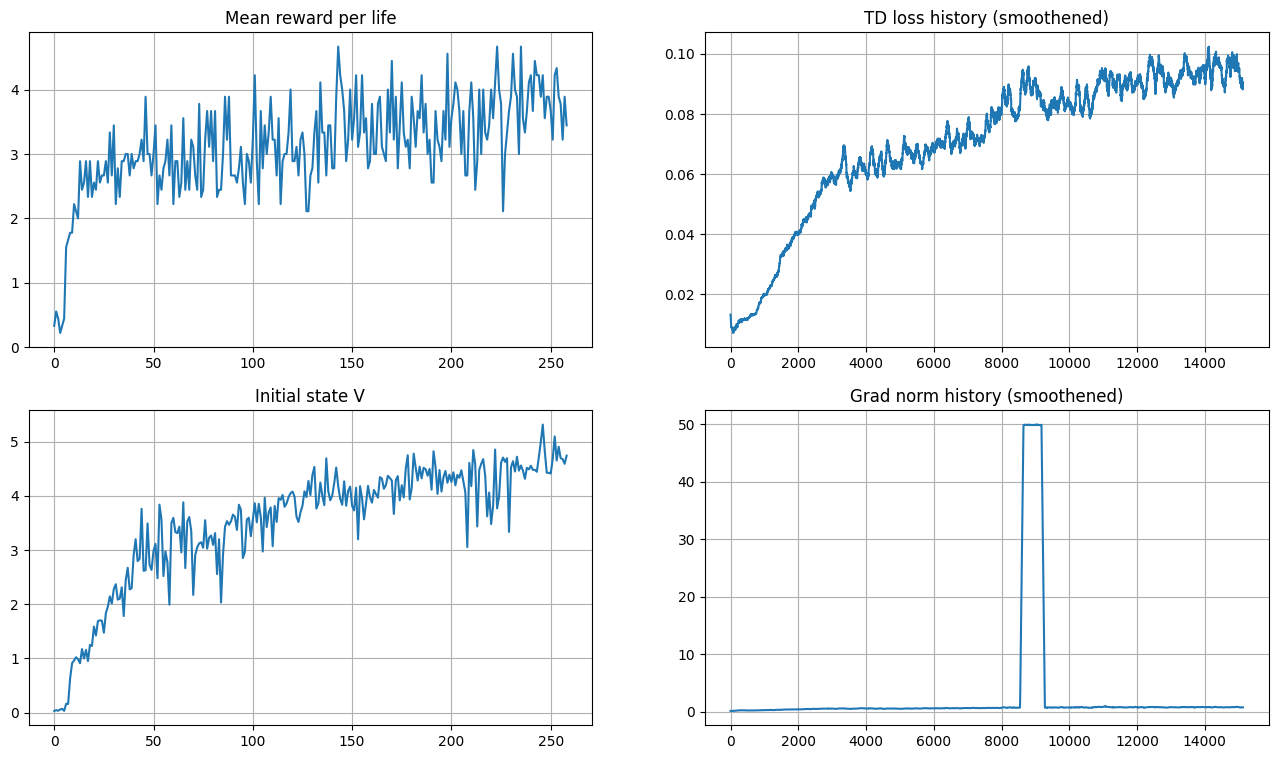

 10%|▉         | 297000/3000001 [1:26:36<13:14:44, 56.69it/s]

In [ ]:
ready_to_stop = False
state, _ = env.reset()
for step in trange(total_steps + 1):
    if not utils.is_enough_ram():
        print('less that 100 Mb RAM available, freezing')
        print('make sure everything is ok and make KeyboardInterrupt to continue')
        try:
            while True:
                pass
        except KeyboardInterrupt:
            pass

    agent.epsilon = utils.linear_decay(init_epsilon, final_epsilon, step, decay_steps)

    # play
    _, state = play_and_record(state, agent, env, exp_replay, timesteps_per_epoch)

    # train
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)

    loss = compute_td_loss(obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch,
                          agent, target_network,
                          gamma=0.99)

    opt.zero_grad(set_to_none=True)
    loss.backward()
    grad_norm = nn.utils.clip_grad_norm_(agent.parameters(), max_grad_norm)
    opt.step()

    if step % loss_freq == 0:
        td_loss_history.append(loss.data.cpu().item())
        grad_norm_history.append(grad_norm.cpu().item())

    if step % refresh_target_network_freq == 0:
        # Load agent weights into target_network
        target_network.load_state_dict(agent.state_dict())

    if step % eval_freq == 0:
        mean_rw_history.append(evaluate(
            make_env(clip_rewards=True, seed=step), agent, n_games=3 * 3, greedy=True)
        )
        initial_state_q_values = agent.get_qvalues(
            [make_env(seed=step).reset()[0]]
        )
        initial_state_v_history.append(np.max(initial_state_q_values))

        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" %
              (len(exp_replay), agent.epsilon))

        plt.figure(figsize=[16, 9])

        plt.subplot(2, 2, 1)
        plt.title("Mean reward per life")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(td_loss_history[-1])
        plt.subplot(2, 2, 2)
        plt.title("TD loss history (smoothened)")
        plt.plot(utils.smoothen(td_loss_history))
        plt.grid()

        plt.subplot(2, 2, 3)
        plt.title("Initial state V")
        plt.plot(initial_state_v_history)
        plt.grid()

        plt.subplot(2, 2, 4)
        plt.title("Grad norm history (smoothened)")
        plt.plot(utils.smoothen(grad_norm_history))
        plt.grid()
        plt.show()
        if len(mean_rw_history) > 1 and mean_rw_history[-1] > 100:
            if ready_to_stop:
                break
            else:
                ready_to_stop = True
        else:
            ready_to_stop = False

Agent is evaluated for 1 life, not for a whole episode of 5 lives. Rewards in evaluation are also truncated. Cuz this is what environment the agent is learning in and in this way mean rewards per life can be compared with initial state value

**The goal is to get 20 points in the real env**. So 4 points in the preprocessed one will probably be enough. You can interrupt learning then.

Final scoring is done on a whole episode with all 5 lives.

In [37]:
final_score = evaluate(
  make_env(clip_rewards=False, seed=9),
    agent, n_games=30, greedy=True, t_max=10 * 1000
) * n_lives
print('final score:', final_score)
assert final_score > 20, 'not as cool as DQN can'
print('Cool!')

final score: 22.0
Cool!


In [35]:
from pathlib import Path
checkpoints = Path('./checkpoints').resolve()

In [ ]:
checkpoints.mkdir(exist_ok=True)
torch.save(
    agent.state_dict(),
    checkpoints / 'score_last.pth'
)

In [36]:
agent.load_state_dict(torch.load(checkpoints / 'score_4.pth'))

<All keys matched successfully>

## How to interpret plots:

This aint no supervised learning so don't expect anything to improve monotonously.
* **TD loss** is the MSE between agent's current Q-values and target Q-values. It may slowly increase or decrease, it's ok. The "not ok" behavior includes going NaN or stayng at exactly zero before agent has perfect performance.
* **grad norm** just shows the intensivity of training. Not ok is growing to values of about 100 (or maybe even 50) though it depends on network architecture.
* **mean reward** is the expected sum of r(s,a) agent gets over the full game session. It will oscillate, but on average it should get higher over time (after a few thousand iterations...).
 * In basic q-learning implementation it takes about 40k steps to "warm up" agent before it starts to get better.
* **Initial state V** is the expected discounted reward for episode in the oppinion of the agent. It should behave more smoothly than **mean reward**. It should get higher over time but sometimes can experience drawdowns because of the agent's overestimates.
* **buffer size** - this one is simple. It should go up and cap at max size.
* **epsilon** - agent's willingness to explore. If you see that agent's already at 0.01 epsilon before it's average reward is above 0 - it means you need to increase epsilon. Set it back to some 0.2 - 0.5 and decrease the pace at which it goes down.
* Smoothing of plots is done with a gaussian kernel

At first your agent will lose quickly. Then it will learn to suck less and at least hit the ball a few times before it loses. Finally it will learn to actually score points.

**Training will take time.** A lot of it actually. Probably you will not see any improvment during first **150k** time steps (note that by default in this notebook agent is evaluated every 5000 time steps).

## About hyperparameters:

The task has something in common with supervised learning: loss is optimized through the buffer (instead of Train dataset). But the distribution of states and actions in the buffer **is not stationary** and depends on the policy that generated it. It can even happen that the mean TD error across the buffer is very low but the performance is extremely poor (imagine the agent collecting data to the buffer always manages to avoid the ball).

* Total timesteps and training time: It seems to be so huge, but actually it is normal for RL.

* $\epsilon$ decay shedule was taken from the original paper and is like traditional for epsilon-greedy policies. At the beginning of the training the agent's greedy policy is poor so many random actions should be taken.

* Optimizer: In the original paper RMSProp was used (they did not have Adam in 2013) and it can work not worse than Adam. For us Adam was default and it worked.

* lr: $10^{-3}$ would probably be too huge

* batch size: This one can be very important: if it is too small the agent can fail to learn. Huge batch takes more time to process. If batch of size 8 can not be processed on the hardware you use take 2 (or even 4) batches of size 4, divide the loss on them by 2 (or 4) and make optimization step after both backward() calls in torch.

* target network update frequency: has something in common with learning rate. Too frequent updates can lead to divergence. Too rare can lead to slow leraning. For millions of total timesteps thousands of inner steps seem ok. One iteration of target network updating is an iteration of the (this time approximate) $\gamma$-compression that stands behind Q-learning. The more inner steps it makes the more accurate is the compression.
* max_grad_norm - just huge enough. In torch clip_grad_norm also evaluates the norm before clipping and it can be convenient for logging.

# Record a video

In [38]:
# record sessions
from gymnasium.wrappers import RecordVideo

with RecordVideo(env=make_env(), video_folder='./videos2',
                 episode_trigger = lambda episode_number: True) as env_monitor:
    sessions = [evaluate(env_monitor, agent, n_games=n_lives,
                         greedy=True) for _ in range(10)]
env.close()

In [88]:
# Show video. This may not work in some setups. If it doesn't
# work for you, you can download the videos and view them locally.

from pathlib import Path
from base64 import b64encode
from IPython.display import HTML
import sys

video_paths = sorted([s for s in Path('videos').iterdir() if s.suffix == '.mp4'])
video_path = video_paths[0]  # You can also try other indices

if 'google.colab' in sys.modules:
    # https://stackoverflow.com/a/57378660/1214547
    with video_path.open('rb') as fp:
        mp4 = fp.read()
    data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
else:
    data_url = str(video_path)

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format(data_url))

# Let's have a closer look at this (up to 1 point)

Make a more complete record of an episode.

In [44]:
eval_env = make_env(clip_rewards=False)
record = utils.play_and_log_episode(eval_env, agent)
print('total reward for life:', np.sum(record['rewards']))
for key in record:
    print(key)

total reward for life: 5.0
states
v_mc
v_agent
q_spreads
td_errors
rewards
episode_finished


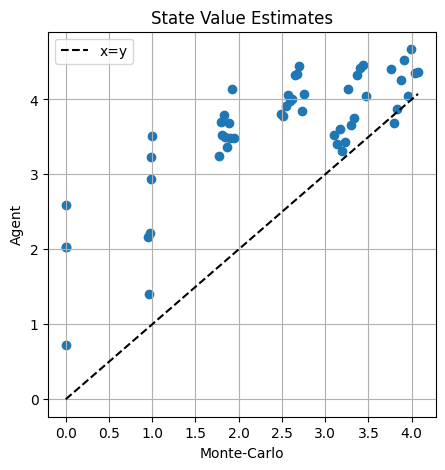

In [45]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(record['v_mc'], record['v_agent'])
ax.plot(sorted(record['v_mc']), sorted(record['v_mc']),
       'black', linestyle='--', label='x=y')

ax.grid()
ax.legend()
ax.set_title('State Value Estimates')
ax.set_xlabel('Monte-Carlo')
ax.set_ylabel('Agent')

plt.show()

$\hat V_{Monte-Carlo}(s_t) = \sum_{\tau=0}^{episode~end} \gamma^{\tau-t}r_t$

Is there a big bias? It's ok, anyway it works.

**1.** Plot several (say 3) states with high and low spreads of Q estimate by actions i.e.
$$\max_a \hat Q(s,a) - \min_a \hat Q(s,a)\$$
Please take those states from different episodes to make sure that the states are really different.

What should high and low spread mean at least in the world of perfect Q-fucntions?

Comment the states you like most.

**2.** Plot several (say 3) states with high td-error and several states with high values of
$$| \hat V_{Monte-Carlo}(s) - \hat V_{agent}(s)|,$$
$$\hat V_{agent}(s) = \max_a \hat Q(s,a).$$

Please take those states from different episodes to make sure that the states are really different. From what part (i.e. beginning, middle, end) of an episode did these states come from?

Comment the states you like most.

In [90]:
from utils import play_and_log_episode, img_by_obs

def plot_states(obs, title=''):
    fig = plt.figure(figsize=[15, 15])
    cols = len(obs)
    rows = 1
    for i, (o, n) in enumerate(obs, start=1):
        ax = fig.add_subplot(rows, cols, i)
        ax.imshow(utils.img_by_obs(o, o.shape), cmap='gray')
        ax.set_title(f'value: {n:.3f}')
    fig.suptitle(title)
    plt.show()

In [91]:
state_shape = eval_env.observation_space.shape
max_spreads = []
min_spreads = []
for i in range(3):
    record = utils.play_and_log_episode(eval_env, agent)
    spread_states = [(record['states'][i], record['q_spreads'][i]) for i in range(len(record['states']))]
    sorted_spreads = sorted(spread_states, key=lambda x: x[1])
    max_spreads.append(sorted_spreads[-1])
    min_spreads.append(sorted_spreads[0])

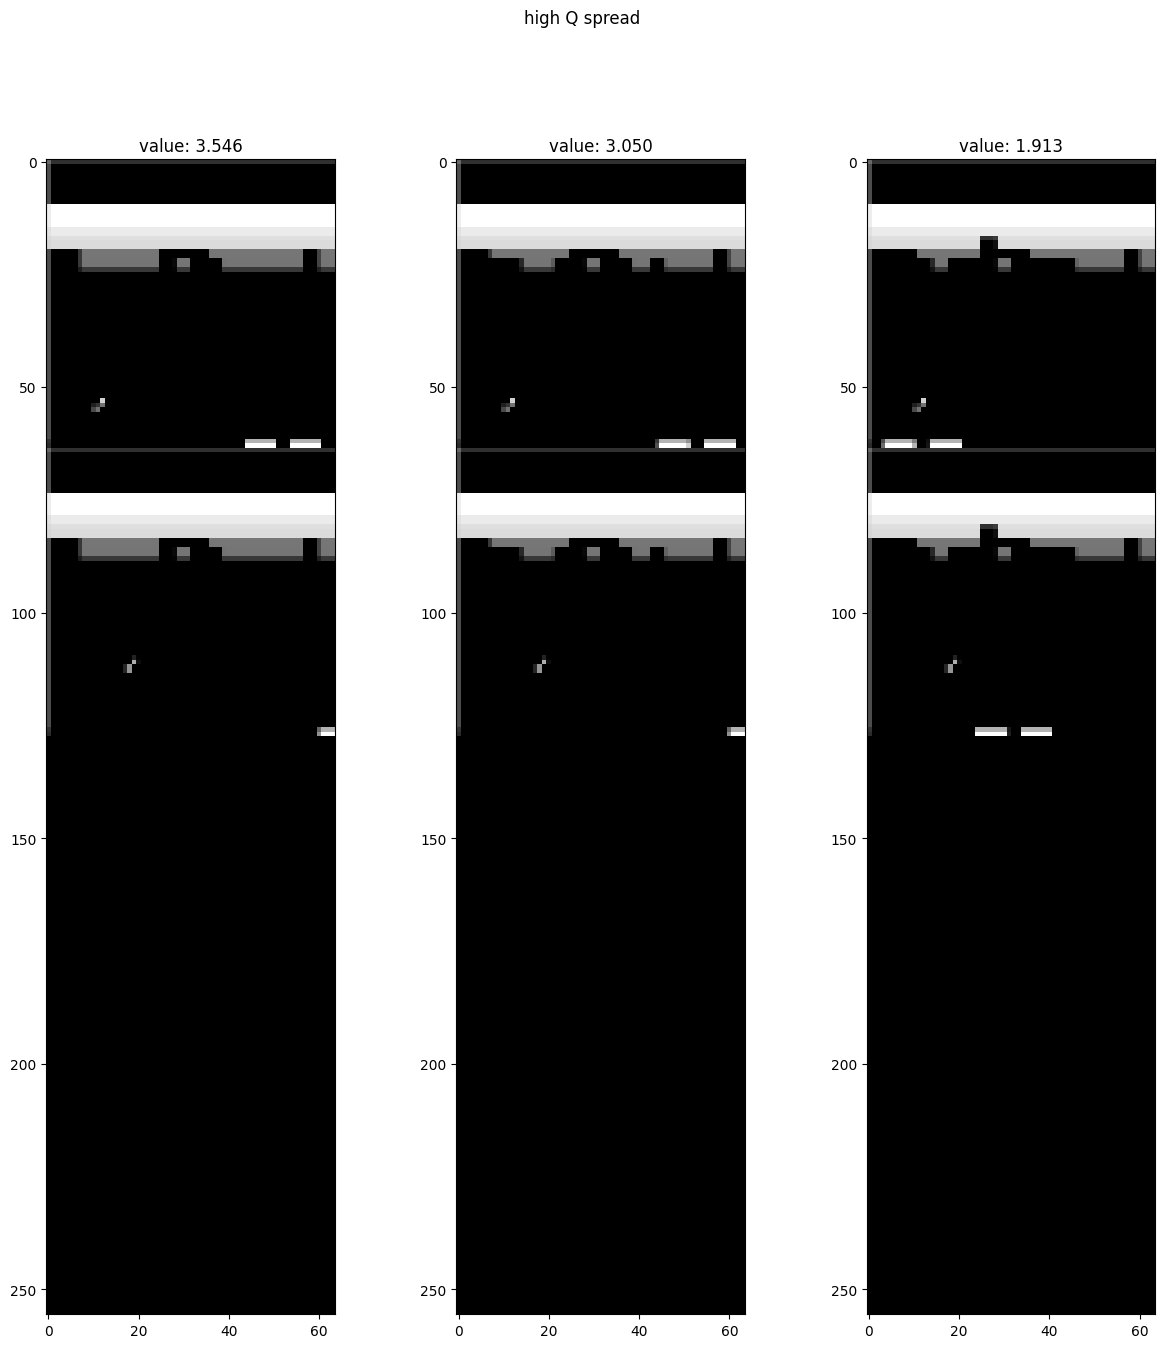

In [92]:
plot_states(max_spreads, 'high Q spread')

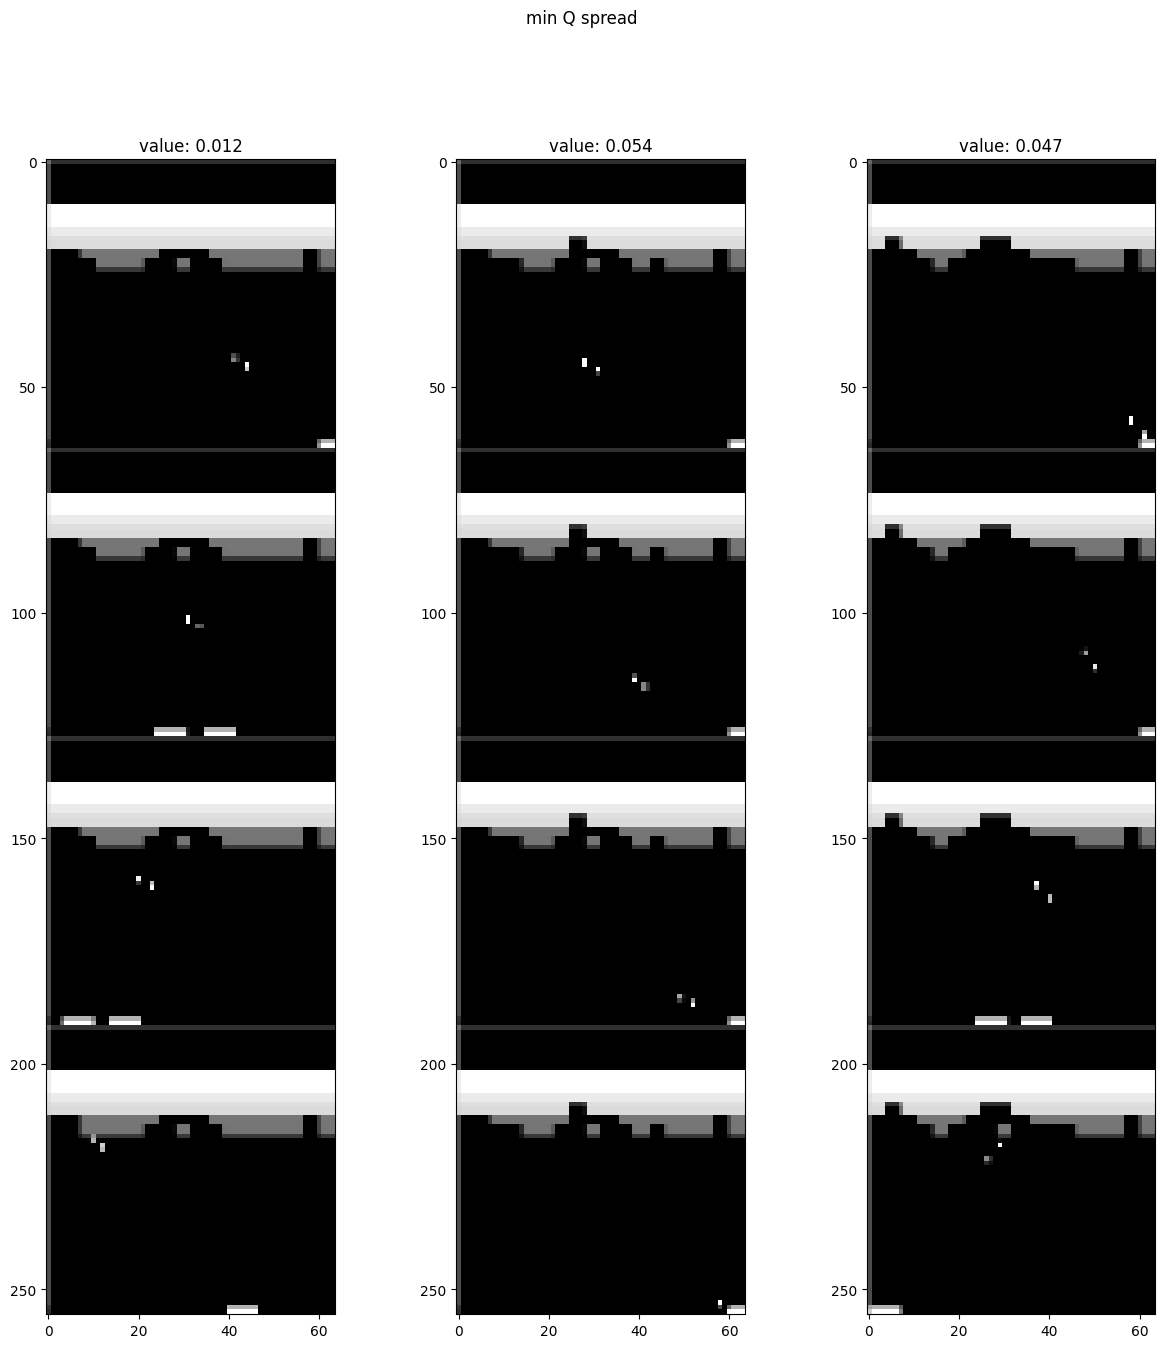

In [93]:
plot_states(min_spreads, 'min Q spread')

What should high and low spread mean at least in the world of perfect Q-functions?

High spread in terms of optimal Q-function signals that confidence in the action is high. 
On the other hand, if the spread is low, the agent is not confident that a specific action is the best; also, when the spread is low, the agent might explore more. 

As a result, in most states, high spread is achieved when the ball flies down, because failing the game depends on the action and the cost of error is high.

Low spread is achieved when the ball flies up because there is no need to do anything to update the game score, and no action improves the game score.

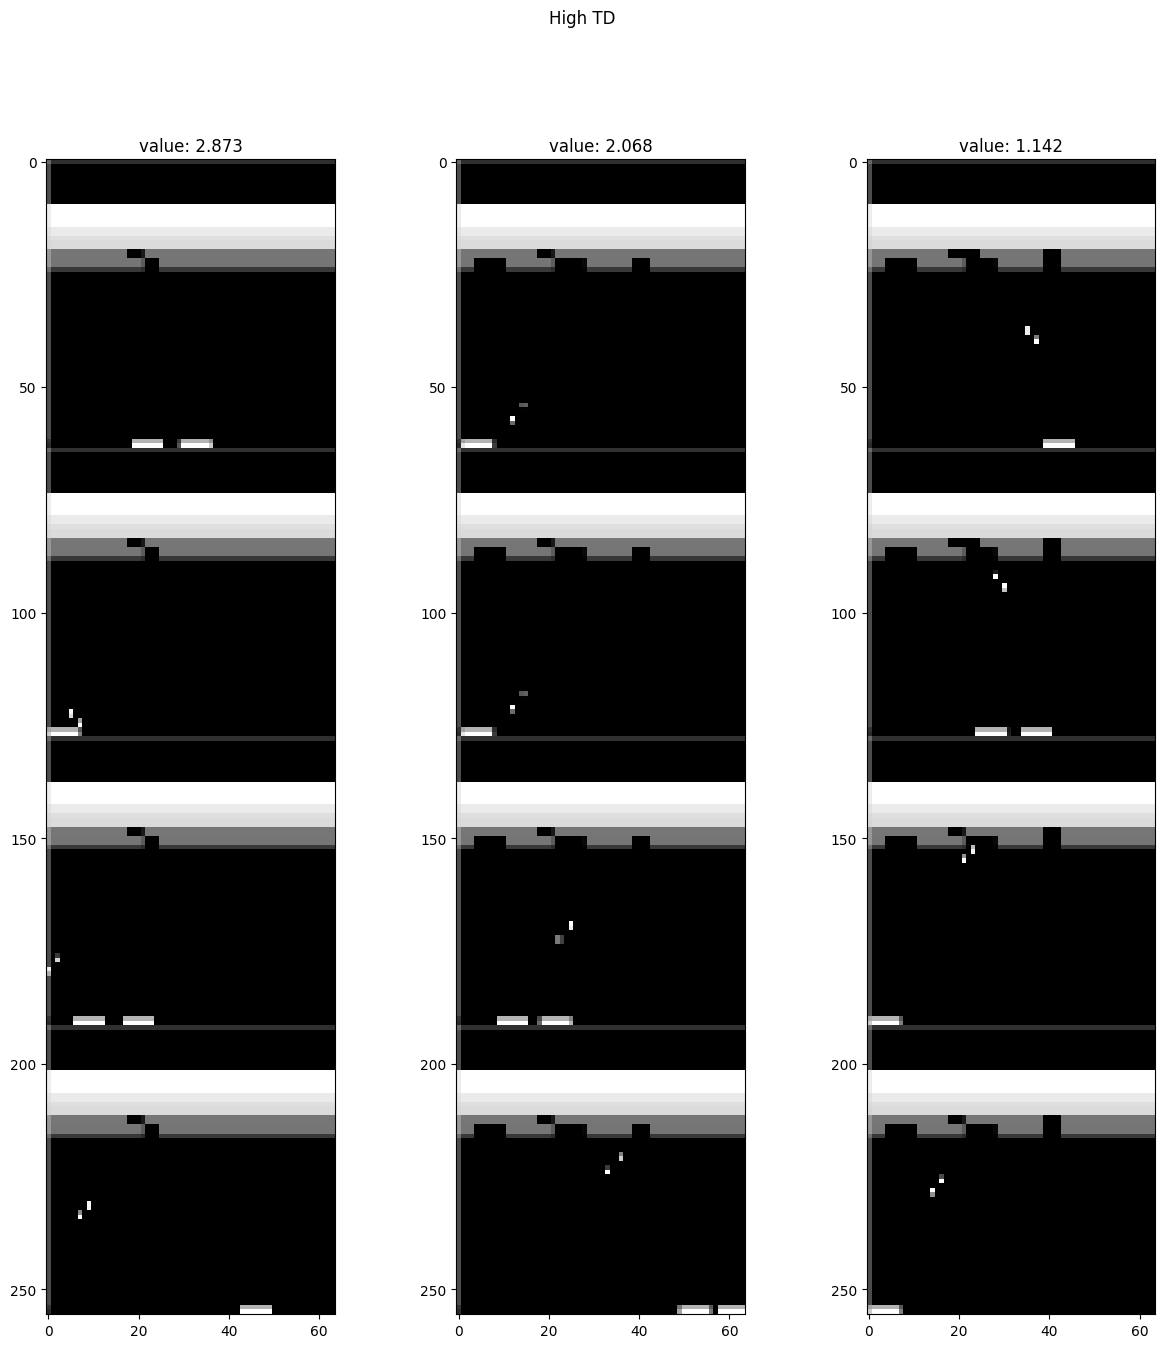

In [104]:
state_shape = eval_env.observation_space.shape
high_td = []
for i in range(3):
    record = utils.play_and_log_episode(eval_env, agent)
    td_states = [(record['states'][i], record['td_errors'][i]) for i in range(len(record['states']))]
    td_states = sorted(td_states, key=lambda x: x[1])
    high_td.append(td_states[-1])
plot_states(high_td, 'High TD')

Most of states is from losing the game time, because agent expect more future value.

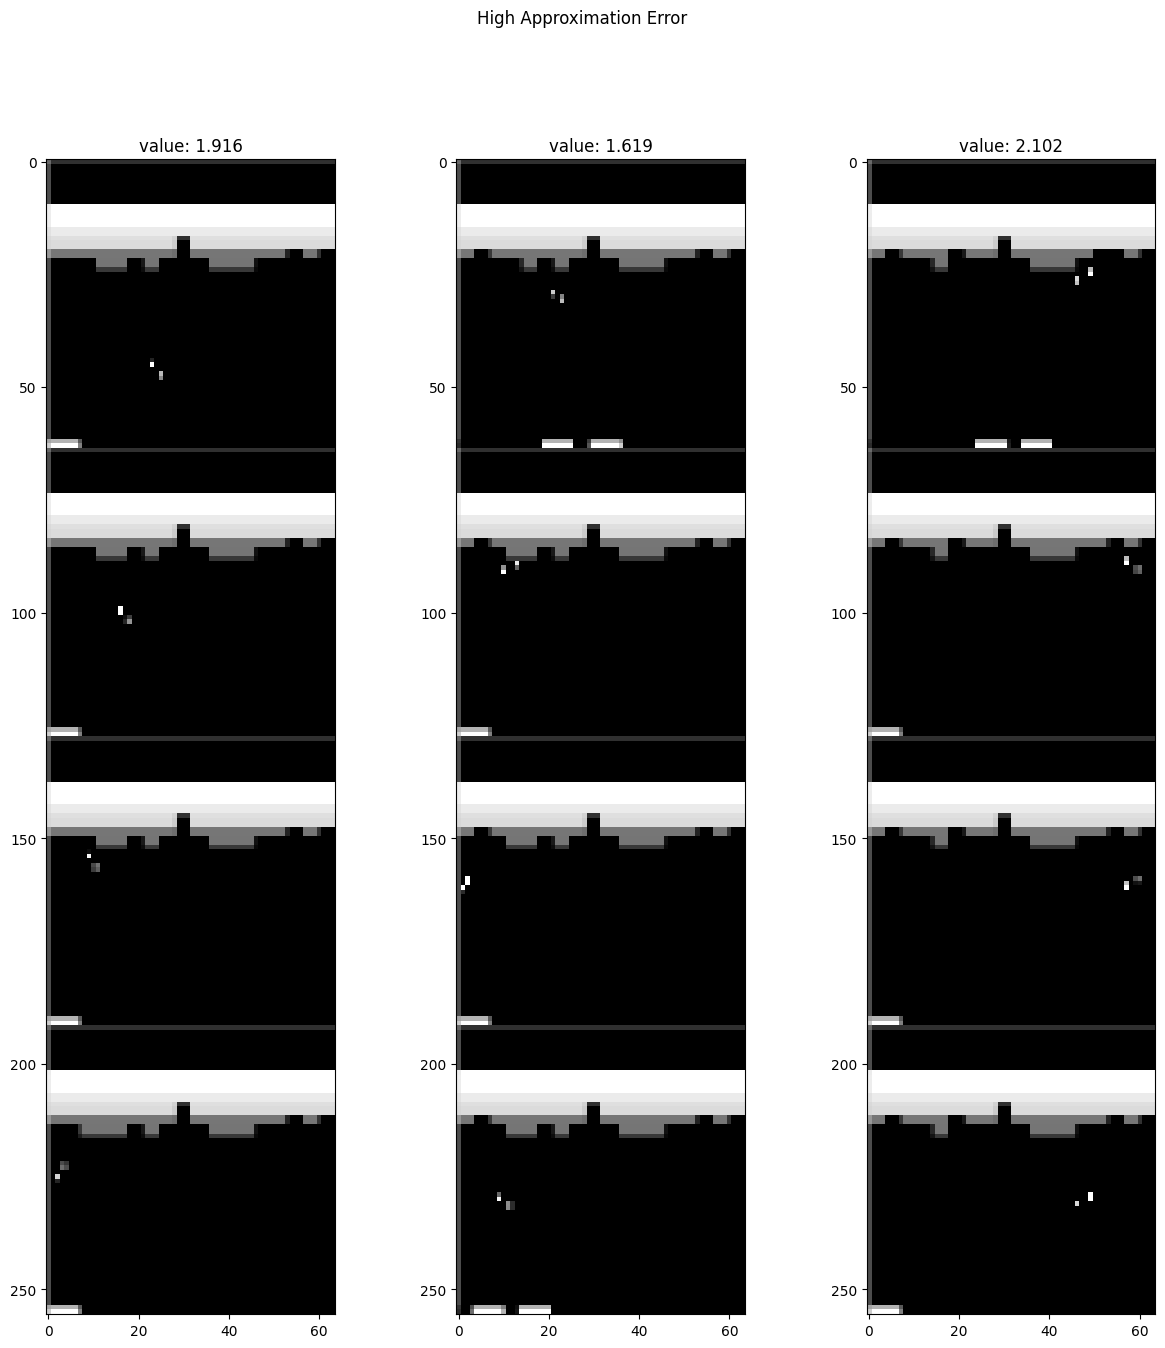

In [103]:
state_shape = eval_env.observation_space.shape
approx_errors = []
for i in range(3):
    record = utils.play_and_log_episode(eval_env, agent)
    states = record['states']
    error = np.abs(record['v_mc'] - record['v_agent'])
    sorted_errors = sorted(zip(states, error), key=lambda x: x[1])
    approx_errors.append(sorted_errors[-1])
plot_states(approx_errors, 'High Approximation Error')

In [ ]:
import imageio
from pathlib import Path

prefix = Path("./videos/").resolve().absolute()
video_path = prefix / "game_episode.mp4"
game_episode_files = [prefix / f'rl-video-episode-{i}.mp4' for i in range(0, 5)]
print(game_episode_files)
game_episode_files = [imageio.get_reader(path) for path in game_episode_files]
writer = imageio.get_writer(
    video_path,
    fps = game_episode_files[0].get_meta_data()['fps'],
    codec = "libx264",
    quality = 10,
    pixelformat = "yuv420p"
)

for episode in game_episode_files:
    for frame in episode:
        writer.append_data(frame)
    episode.close()
writer.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (160, 210) to (160, 224) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


[PosixPath('/Users/azrail/Desktop/ml/RL/DDQN/videos/rl-video-episode-0.mp4'), PosixPath('/Users/azrail/Desktop/ml/RL/DDQN/videos/rl-video-episode-1.mp4'), PosixPath('/Users/azrail/Desktop/ml/RL/DDQN/videos/rl-video-episode-2.mp4'), PosixPath('/Users/azrail/Desktop/ml/RL/DDQN/videos/rl-video-episode-3.mp4'), PosixPath('/Users/azrail/Desktop/ml/RL/DDQN/videos/rl-video-episode-4.mp4')]


In [14]:
from moviepy import VideoFileClip, VideoClip

gif_path = video_path.with_suffix('.gif')
clip = VideoFileClip(str(video_path))


clip.write_gif(
    str(gif_path),
)
clip.close()

{'video_found': True, 'audio_found': False, 'metadata': {'major_brand': 'isom', 'minor_version': '512', 'compatible_brands': 'isomiso2avc1mp41', 'encoder': 'Lavf61.7.100'}, 'inputs': [{'streams': [{'input_number': 0, 'stream_number': 0, 'stream_type': 'video', 'language': None, 'default': True, 'size': [160, 224], 'bitrate': 83, 'fps': 30.0, 'codec_name': 'h264', 'profile': '(High 4:4:4 Predictive)', 'metadata': {'Metadata': '', 'handler_name': 'VideoHandler', 'vendor_id': '[0][0][0][0]', 'encoder': 'Lavc61.19.100 libx264'}}], 'input_number': 0}], 'duration': 5.9, 'bitrate': 85, 'start': 0.0, 'default_video_input_number': 0, 'default_video_stream_number': 0, 'video_codec_name': 'h264', 'video_profile': '(High 4:4:4 Predictive)', 'video_size': [160, 224], 'video_bitrate': 83, 'video_fps': 30.0, 'video_duration': 5.9, 'video_n_frames': 177}
/Users/azrail/Desktop/ml/RL/.venv/lib/python3.10/site-packages/imageio_ffmpeg/binaries/ffmpeg-macos-aarch64-v7.1 -i /Users/azrail/Desktop/ml/RL/DDQN/

# Bonus area
# Apply modifications to DQN

For inspiration see [Rainbow](https://arxiv.org/abs/1710.02298) - a version of q-learning that combines lots of them.

* [Quantile Regression DQN](https://arxiv.org/abs/1710.10044) (1.5 pt)
* [Prioritized Experience Replay](https://arxiv.org/abs/1710.10044) (2 pt)
* [n-step target without off-policy correction](https://arxiv.org/abs/1901.07510) (1 pt)
* [Clipped Double DQN](https://arxiv.org/abs/1802.09477v3) (0.5 pt)
* [Noisy networks](https://arxiv.org/abs/1706.10295) (1 pts)
* [DRQN](https://arxiv.org/abs/1507.06527) (3 pt)